# HMM & CTC Lab Exam Cheatsheet

Quick copy-paste solutions with documentation references for:
- **HMM**: Hidden Markov Models using `hmmlearn`
- **CTC**: Connectionist Temporal Classification using `PyTorch`

---
# Part 1: HMM (Hidden Markov Models)

**Documentation**: https://hmmlearn.readthedocs.io/en/stable/tutorial.html

## 1.1 Installation & Imports

In [ ]:
!pip install hmmlearn librosa python_speech_features

import numpy as np
import librosa
from hmmlearn import hmm
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 6.2 MB/s eta 0:00:00
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=0fffb5818214d942cce90607f84ed14928229dd04a1b624c18c9f384794360fa
  Stored in directory: /root/.cache/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features


## 1.2 Feature Extraction (MFCC)

**Ref**: https://librosa.org/doc/main/generated/librosa.feature.mfcc.html

In [ ]:
# Load audio and extract MFCC features
y, sr = librosa.load('sample.wav', sr=16000)

# Extract MFCC features (13 coefficients is standard)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mfcc = mfcc.T  # Shape: (n_frames, n_features)

print(f"MFCC shape: {mfcc.shape}")

MFCC shape: (94, 13)


## 1.3 Create & Train GaussianHMM

**Ref**: https://hmmlearn.readthedocs.io/en/stable/api.html#hmmlearn.hmm.GaussianHMM

In [ ]:
# Create GaussianHMM model
n_states = 5  # Number of hidden states (phonemes)
model = hmm.GaussianHMM(
    n_components=n_states,      # Number of hidden states
    covariance_type='diag',     # 'diag', 'full', 'tied', 'spherical'
    n_iter=100,                 # Max EM iterations
    random_state=42
)

# Train the model (fit)
model.fit(mfcc)

print("Model trained!")
print(f"Converged: {model.monitor_.converged}")

Model trained!
Converged: True


## 1.4 Training with Multiple Sequences

**Ref**: https://hmmlearn.readthedocs.io/en/stable/tutorial.html#working-with-multiple-sequences

In [ ]:
# Training with multiple audio files
# Concatenate all features and track lengths

audio_files = ['audio1.wav', 'audio2.wav']
all_features = []
lengths = []

for f in audio_files:
    y, sr = librosa.load(f, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T
    all_features.append(mfcc)
    lengths.append(len(mfcc))

X = np.concatenate(all_features)  # Concatenate all
lengths = np.array(lengths)       # Array of sequence lengths

# Train with multiple sequences
model = hmm.GaussianHMM(n_components=5, n_iter=100)
model.fit(X, lengths)

GaussianHMM(n_components=5, n_iter=100)

## 1.5 Inspect Model Parameters

In [ ]:
# Initial state probabilities (π)
print("Initial state probabilities (startprob_):")
print(model.startprob_)

# Transition matrix (A)
print("\nTransition matrix (transmat_):")
print(model.transmat_)

# Emission means (μ)
print("\nEmission means (means_):")
print(model.means_.shape)  # (n_states, n_features)

# Emission covariances (Σ)
print("\nEmission covariances (covars_):")
print(model.covars_.shape)

Initial state probabilities (startprob_):
[0. 1. 0. 0. 0.]

Transition matrix (transmat_):
[[8.74863646e-001 0.00000000e+000 3.12840928e-002 1.01185541e-132
  9.38522607e-002]
 [2.79420743e-166 9.23076923e-001 0.00000000e+000 7.69230769e-002
  2.01451121e-158]
 [9.09996389e-159 0.00000000e+000 8.82368104e-001 5.86305843e-002
  5.90013117e-002]
 [1.73931341e-001 4.34828332e-002 4.34828251e-002 7.39103001e-001
  9.03187313e-040]
 [2.60886437e-052 0.00000000e+000 1.04559546e-079 9.67663115e-002
  9.03233689e-001]]

Emission means (means_):
(5, 13)

Emission covariances (covars_):
(5, 13, 13)


## 1.6 Score (Log-Likelihood) - Using hmmlearn

**Ref**: https://hmmlearn.readthedocs.io/en/stable/api.html#hmmlearn.hmm.GaussianHMM.score

In [ ]:
# Compute log-likelihood of sequence
log_likelihood = model.score(mfcc)
print(f"Log-likelihood: {log_likelihood}")

Log-likelihood: -2807.081790842603


## 1.7 Predict Hidden States (Viterbi) - Using hmmlearn

**Ref**: https://hmmlearn.readthedocs.io/en/stable/api.html#hmmlearn.hmm.GaussianHMM.predict

In [ ]:
# Decode most likely state sequence using Viterbi
hidden_states = model.predict(mfcc)
print(f"Hidden states: {hidden_states}")

# Also get log-likelihood with decode
logprob, hidden_states = model.decode(mfcc, algorithm='viterbi')
print(f"Log probability: {logprob}")
print(f"Hidden states: {hidden_states}")

Hidden states: [1 1 3 0 0 0 0 0 0 0 0 0 0 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 2 2 2 2
 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 4 4 4]
Log probability: -2807.238119895004
Hidden states: [1 1 3 0 0 0 0 0 0 0 0 0 0 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 2 2 2 2
 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 4 4 4]


---
## 1.8 Forward Algorithm Implementation from scratch

    

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

# ===========================================================
# FORWARD ALGORITHM - Step by Step
# ===========================================================

def forward_algorithm(obs, model):
    """
    STEP 1: Get dimensions
    STEP 2: Get parameters from model
    STEP 3: Define emission function
    STEP 4: Initialize alpha (t=0)
    STEP 5: Loop forward (t=1 to T-1)
    STEP 6: Sum final alphas
    """

    # STEP 1: Dimensions
    T = len(obs)              # Number of time steps
    N = model.n_components    # Number of states

    # STEP 2: Get parameters
    pi = model.startprob_     # Initial: π
    A = model.transmat_       # Transition: A
    means = model.means_      # Emission means: μ
    covars = model.covars_    # Emission covariances: Σ

    # STEP 3: Emission probability function
    def B(o, j):
        """Probability of observation o in state j"""
        return multivariate_normal.pdf(o, means[j], np.diag(covars[j]))

    # STEP 4: Initialize (t=0)
    alpha = np.zeros((T, N))
    for j in range(N):
        alpha[0, j] = pi[j] * B(obs[0], j)

    # STEP 5: Forward recursion (t=1 to T-1)
    for t in range(1, T):
        for j in range(N):
            # Sum over all previous states
            total = 0
            for i in range(N):
                total += alpha[t-1, i] * A[i, j]
            alpha[t, j] = total * B(obs[t], j)

    # STEP 6: Termination
    prob = np.sum(alpha[-1])
    log_prob = np.log(prob + 1e-300)

    return log_prob, alpha
q, _ = forward_algorithm(mfccs.T, model)

print(f"Forward: {q:.2f} vs hmmlearn: {model.score(mfccs.T):.2f}")


My Forward log-likelihood: -690.7755278982137
hmmlearn score: -2807.081790842603


## 1.9 Viterbi Algorithm Implementation from scratch



In [ ]:
def viterbi_algorithm(obs, model):
    """
    STEP 1: Get dimensions
    STEP 2: Get parameters (use log!)
    STEP 3: Define log emission function
    STEP 4: Initialize delta & psi (t=0)
    STEP 5: Loop forward, track best (t=1 to T-1)
    STEP 6: Backtrack to get path
    """

    # STEP 1: Dimensions
    T = len(obs)
    N = model.n_components

    # STEP 2: Get parameters (USE LOG!)
    pi = model.startprob_
    A = model.transmat_
    means = model.means_
    covars = model.covars_

    log_pi = np.log(pi + 1e-300)
    log_A = np.log(A + 1e-300)

    # STEP 3: Log emission function
    def log_B(o, j):
        """Log probability of observation o in state j"""
        return multivariate_normal.logpdf(o, means[j], np.diag(covars[j]))

    # STEP 4: Initialize (t=0)
    delta = np.zeros((T, N))  # Best score to state j at time t
    psi = np.zeros((T, N), dtype=int)  # Best previous state

    for j in range(N):
        delta[0, j] = log_pi[j] + log_B(obs[0], j)
        psi[0, j] = 0

    # STEP 5: Forward recursion (t=1 to T-1)
    for t in range(1, T):
        for j in range(N):
            # Find best previous state
            scores = delta[t-1] + log_A[:, j]
            psi[t, j] = np.argmax(scores)
            delta[t, j] = np.max(scores) + log_B(obs[t], j)

    # STEP 6: Backtrack
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(delta[-1])  # Start from best final state

    for t in range(T-2, -1, -1):  # Go backwards
        path[t] = psi[t+1, path[t+1]]

    best_score = delta[-1, path[-1]]

    return path, best_score
my_path, _ = viterbi_algorithm(mfccs.T, model)

print(f"Viterbi match: {np.array_equal(my_path, model.predict(mfccs.T))}")

My Viterbi path: [1 1 3 0 0 0 0 0 0 0 0 0 0 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 2 2 2 2
 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 4 4 4]
hmmlearn path:   [1 1 3 0 0 0 0 0 0 0 0 0 0 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 2 2 2 2
 2 2 2 3 3 2 2 2 2 2 2 2 2 2 2 4 4 4]
Paths match: True


## 1.2 Word Recognition with Multiple HMMs "If asked to use large datasets"

In [ ]:
## 1.10 Word Recognition with Multiple HMMs - LibriSpeech Dataset

import glob
import os
import tarfile

# Download LibriSpeech sample (free alternative to TIMIT)
def download_speech_data():
    if not os.path.exists('LibriSpeech'):
        print("Downloading LibriSpeech dev-clean (337 MB)...")
        import urllib.request

        # Using verified working link from openslr.org
        url = "https://www.openslr.org/resources/12/dev-clean.tar.gz"

        urllib.request.urlretrieve(url, "speech.tar.gz")
        print("Extracting...")
        with tarfile.open("speech.tar.gz", 'r:gz') as tar:
            tar.extractall()
        os.remove("speech.tar.gz")
        print("✓ Dataset downloaded successfully")
    return "LibriSpeech/dev-clean"

# Extract features from audio file
def extract_mfcc(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        return mfcc.T
    except:
        return None

# Train one HMM per speaker
data_path = download_speech_data()
word_models = {}

# Get all audio files and group by speaker
all_wavs = glob.glob(f'{data_path}/**/*.flac', recursive=True)
print(f"Found {len(all_wavs)} audio files")

# Group by speaker (speaker ID is in path)
from collections import defaultdict
speaker_groups = defaultdict(list)

for wav in all_wavs[:50]:  # Use first 50 files
    # Extract speaker ID from path: .../dev-clean/SPEAKER_ID/...
    parts = wav.split(os.sep)
    speaker_id = parts[-3] if len(parts) >= 3 else 'unknown'
    speaker_groups[speaker_id].append(wav)

# Use top 3 speakers as "words"
speakers = sorted(speaker_groups.keys(), key=lambda x: len(speaker_groups[x]), reverse=True)[:3]

for speaker in speakers:
    print(f"Training model for speaker: {speaker}")

    audio_files = speaker_groups[speaker]

    # Extract features from all files
    all_features = []
    lengths = []

    for audio_file in audio_files:
        mfcc = extract_mfcc(audio_file)
        if mfcc is not None:
            all_features.append(mfcc)
            lengths.append(len(mfcc))

    if not all_features:
        continue

    # Concatenate and train
    X = np.concatenate(all_features)
    model = hmm.GaussianHMM(n_components=5, n_iter=100, covariance_type='diag')
    model.fit(X, lengths)

    word_models[speaker] = model
    print(f"  ✓ Trained on {len(audio_files)} files")

# Recognition: find word with highest likelihood
def recognize_word(test_features, word_models):
    best_word = None
    best_score = float('-inf')

    for word, model in word_models.items():
        score = model.score(test_features)
        if score > best_score:
            best_score = score
            best_word = word

    return best_word, best_score

# Test recognition
print("\nTesting recognition:")
test_files = all_wavs[:5]

for test_file in test_files:
    test_mfcc = extract_mfcc(test_file)
    if test_mfcc is not None:
        word, score = recognize_word(test_mfcc, word_models)
        print(f"{os.path.basename(test_file)} -> Speaker {word} (score: {score:.2f})")

Extracting...


/tmp/ipython-input-1698534466.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


✓ Dataset downloaded successfully
Found 2703 audio files
Training model for speaker: 251
  ✓ Trained on 50 files

Testing recognition:
251-118436-0000.flac -> Speaker 251 (score: -10026.40)
251-118436-0006.flac -> Speaker 251 (score: -11965.77)
251-118436-0010.flac -> Speaker 251 (score: -4881.36)
251-118436-0001.flac -> Speaker 251 (score: -6149.44)
251-118436-0004.flac -> Speaker 251 (score: -5676.53)


---
# Part 2: CTC (Connectionist Temporal Classification)

**Documentation**:
- https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
- https://distill.pub/2017/ctc/
- https://pytorch.org/audio/stable/tutorials/ctc_forced_alignment_api_tutorial.html

## 2.1 Installation & Imports

In [ ]:
# pip install torch torchaudio librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import librosa
import numpy as np

## 2.2 Feature Extraction for CTC

In [ ]:
# Load audio and extract features
y, sr = librosa.load('audio1.wav', sr=16000)

# Extract MFCC or Mel spectrogram
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
features = torch.FloatTensor(mfcc.T)  # (T, n_features)

print(f"Features shape: {features.shape}")

Features shape: torch.Size([76, 13])


## 2.3 Simple LSTM Model with CTC

**Ref**: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [ ]:
class SimpleCTCModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim: number of input features (e.g., 13 for MFCC)
            hidden_dim: LSTM hidden size
            output_dim: number of classes (phonemes + blank)
        """
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2,
                           batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional

    def forward(self, x):
        # x: (batch, time, features)
        lstm_out, _ = self.lstm(x)       # (batch, time, hidden*2)
        logits = self.fc(lstm_out)       # (batch, time, output_dim)
        log_probs = F.log_softmax(logits, dim=-1)  # CTC needs log probabilities
        return log_probs

# Example
n_phonemes = 39  # TIMIT has 39 phonemes
n_classes = n_phonemes + 1  # +1 for blank label

model = SimpleCTCModel(input_dim=13, hidden_dim=128, output_dim=n_classes)
print(model)

SimpleCTCModel(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=40, bias=True)
)


## 2.4 CTC Loss Function

**Ref**: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html

In [ ]:
# Create CTC Loss
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

# Example inputs
batch_size = 2
T = 50  # Input sequence length (time frames)
C = 40  # Number of classes (phonemes + blank)
S = 10  # Max target length

# Model output: log probabilities, shape (T, N, C)
log_probs = torch.randn(T, batch_size, C).log_softmax(dim=2)

# Target sequences (phoneme indices, blank=0 cannot be target)
targets = torch.randint(1, C, (batch_size, S))  # Exclude blank (0)

# Input lengths (actual length of each sequence in batch)
input_lengths = torch.full((batch_size,), T, dtype=torch.long)

# Target lengths (actual length of each target)
target_lengths = torch.randint(3, S, (batch_size,), dtype=torch.long)

# Compute loss
loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
print(f"CTC Loss: {loss.item()}")

CTC Loss: 30.79225730895996


## 2.5 Training Loop with CTC

In [ ]:
# Training setup
model = SimpleCTCModel(input_dim=13, hidden_dim=128, output_dim=40)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

# Training loop
def train_step(features, targets, input_lengths, target_lengths):
    model.train()
    optimizer.zero_grad()

    # Forward pass: (batch, time, features) -> (batch, time, classes)
    log_probs = model(features)

    # CTC expects (time, batch, classes)
    log_probs = log_probs.permute(1, 0, 2)  # (T, N, C)

    # Compute CTC loss
    loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)

    # Backward pass
    loss.backward()
    optimizer.step()

    return loss.item()

## 2.6 Greedy CTC Decoding

**Simple decoding**: Take argmax at each time step, then collapse repeats and remove blanks

In [ ]:
def greedy_decode(log_probs, blank=0):
    """
    Greedy CTC decoding

    Args:
        log_probs: (T, C) log probabilities from model
        blank: blank label index

    Returns:
        decoded: list of predicted labels (no blanks, no repeats)
    """
    # Get best label at each time step
    best_labels = torch.argmax(log_probs, dim=-1)  # (T,)

    # Collapse repeats and remove blanks
    decoded = []
    prev_label = None

    for label in best_labels.tolist():
        if label != blank and label != prev_label:
            decoded.append(label)
        prev_label = label

    return decoded

# Test
model.eval()
with torch.no_grad():
    log_probs = model(features.unsqueeze(0))  # Add batch dim
    log_probs = log_probs.squeeze(0)          # (T, C)

decoded = greedy_decode(log_probs)
print(f"Decoded sequence: {decoded}")

Decoded sequence: [10, 25, 10, 25, 35, 14, 10, 25, 10, 25, 21, 25, 14, 21, 12, 21, 14, 4, 25, 18, 25]


---
## 2.7 CTC Forward Algorithm from scratch

**Ref**: https://distill.pub/2017/ctc/

In [ ]:
def ctc_forward(log_probs, targets, blank=0):
    """
    CTC Forward Algorithm - Compute P(Y|X) by summing over all alignments

    Args:
        log_probs: (T, C) log probabilities from model
        targets: (S,) target label sequence (no blanks)
        blank: blank label index

    Returns:
        log_likelihood: log P(Y|X)
    """
    T = log_probs.shape[0]  # Input length
    S = len(targets)        # Target length

    # Create extended target with blanks: [blank, y1, blank, y2, blank, ...]
    # Length = 2*S + 1
    ext_targets = [blank]
    for label in targets:
        ext_targets.extend([label, blank])
    L = len(ext_targets)  # 2*S + 1

    # Initialize alpha (log domain for stability)
    # alpha[t, s] = log P(prefix of target[:s+1] given input[:t+1])
    NEG_INF = float('-inf')
    alpha = np.full((T, L), NEG_INF)

    # Initialization (t=0)
    alpha[0, 0] = log_probs[0, ext_targets[0]].item()  # Start with blank
    if L > 1:
        alpha[0, 1] = log_probs[0, ext_targets[1]].item()  # First real label

    # Recursion
    def log_add(a, b):
        """Log-sum-exp for two values"""
        if a == NEG_INF:
            return b
        if b == NEG_INF:
            return a
        return max(a, b) + np.log1p(np.exp(-abs(a - b)))

    for t in range(1, T):
        for s in range(L):
            label = ext_targets[s]
            emit = log_probs[t, label].item()

            # Can come from same state
            val = alpha[t-1, s]

            # Can come from previous state
            if s > 0:
                val = log_add(val, alpha[t-1, s-1])

            # Can skip blank if current and s-2 are same non-blank
            if s > 1 and ext_targets[s] != blank and ext_targets[s] != ext_targets[s-2]:
                val = log_add(val, alpha[t-1, s-2])

            alpha[t, s] = val + emit

    # Termination: sum of last two states (ending with blank or last label)
    log_likelihood = log_add(alpha[T-1, L-1], alpha[T-1, L-2])

    return log_likelihood

# Test
test_targets = [1, 5, 3, 8]  # Example phoneme sequence
log_likelihood = ctc_forward(log_probs, test_targets)
print(f"CTC log-likelihood: {log_likelihood}")

CTC log-likelihood: -260.86814520551394


## 2.8 CTC Viterbi Decoding from scratch

In [ ]:
def ctc_viterbi_decode(log_probs, blank=0):
    """
    CTC Viterbi Decoding - Find best alignment and decode

    Args:
        log_probs: (T, C) log probabilities
        blank: blank label index

    Returns:
        best_path: best frame-level labels
        decoded: collapsed output (no repeats, no blanks)
    """
    T, C = log_probs.shape

    # Dynamic programming
    NEG_INF = float('-inf')

    # delta[t, c] = best log prob ending at label c at time t
    delta = np.full((T, C), NEG_INF)
    psi = np.zeros((T, C), dtype=int)  # Backpointer

    # Initialization
    for c in range(C):
        delta[0, c] = log_probs[0, c].item()
        psi[0, c] = c

    # Recursion
    for t in range(1, T):
        for c in range(C):
            # Can come from any label (CTC allows any transitions)
            prev_best = np.argmax(delta[t-1, :])
            delta[t, c] = delta[t-1, prev_best] + log_probs[t, c].item()
            psi[t, c] = prev_best

    # Backtrack
    best_path = np.zeros(T, dtype=int)
    best_path[-1] = np.argmax(delta[-1, :])

    for t in range(T-2, -1, -1):
        best_path[t] = psi[t+1, best_path[t+1]]

    # Collapse repeats and remove blanks
    decoded = []
    prev = None
    for label in best_path:
        if label != blank and label != prev:
            decoded.append(label)
        prev = label

    return best_path, decoded

# Test
best_path, decoded = ctc_viterbi_decode(log_probs)
print(f"Best path: {best_path}")
print(f"Decoded: {decoded}")

Best path: [10 10 25 25 25 25 25 25 10 10 25 25 35 14 10 10 10 25 25 10 10 25 25 25
 25 21 21 25 25 14 14 21 12 12 21 14 14 14 14  4  4  4  4 25 25 25 25 18
 18 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25]
Decoded: [np.int64(10), np.int64(25), np.int64(10), np.int64(25), np.int64(35), np.int64(14), np.int64(10), np.int64(25), np.int64(10), np.int64(25), np.int64(21), np.int64(25), np.int64(14), np.int64(21), np.int64(12), np.int64(21), np.int64(14), np.int64(4), np.int64(25), np.int64(18), np.int64(25)]


## 2.9 CTC Beam Search Decoding

**Ref**: https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html

In [ ]:
def ctc_beam_search(log_probs, beam_width=10, blank=0):
    """
    Simple CTC Beam Search Decoding

    Args:
        log_probs: (T, C) log probabilities
        beam_width: number of beams to keep
        blank: blank label index

    Returns:
        best_seq: best decoded sequence
    """
    T, C = log_probs.shape

    # Each beam: (prefix_tuple, log_prob_blank, log_prob_non_blank)
    NEG_INF = float('-inf')
    beams = {(): (0.0, NEG_INF)}  # Start with empty prefix

    for t in range(T):
        new_beams = {}

        for prefix, (pb, pnb) in beams.items():
            # Total prob for this prefix
            p_prefix = np.logaddexp(pb, pnb)

            for c in range(C):
                p_c = log_probs[t, c].item()

                if c == blank:
                    # Extend with blank
                    new_pb = p_prefix + p_c
                    if prefix in new_beams:
                        new_beams[prefix] = (np.logaddexp(new_beams[prefix][0], new_pb), new_beams[prefix][1])
                    else:
                        new_beams[prefix] = (new_pb, NEG_INF)
                else:
                    # Extend with label
                    if len(prefix) > 0 and prefix[-1] == c:
                        # Same as last label - need blank first
                        new_prefix = prefix  # Just stay (repeat)
                        new_pnb = pnb + p_c
                        # Or extend after blank
                        ext_prefix = prefix + (c,)
                        ext_pnb = pb + p_c

                        if new_prefix in new_beams:
                            new_beams[new_prefix] = (new_beams[new_prefix][0], np.logaddexp(new_beams[new_prefix][1], new_pnb))
                        else:
                            new_beams[new_prefix] = (NEG_INF, new_pnb)

                        if ext_prefix in new_beams:
                            new_beams[ext_prefix] = (new_beams[ext_prefix][0], np.logaddexp(new_beams[ext_prefix][1], ext_pnb))
                        else:
                            new_beams[ext_prefix] = (NEG_INF, ext_pnb)
                    else:
                        # New label
                        new_prefix = prefix + (c,)
                        new_pnb = p_prefix + p_c

                        if new_prefix in new_beams:
                            new_beams[new_prefix] = (new_beams[new_prefix][0], np.logaddexp(new_beams[new_prefix][1], new_pnb))
                        else:
                            new_beams[new_prefix] = (NEG_INF, new_pnb)

        # Prune to beam_width
        sorted_beams = sorted(new_beams.items(), key=lambda x: np.logaddexp(x[1][0], x[1][1]), reverse=True)
        beams = dict(sorted_beams[:beam_width])

    # Return best sequence
    best = max(beams.items(), key=lambda x: np.logaddexp(x[1][0], x[1][1]))
    return list(best[0])

# Test
decoded = ctc_beam_search(log_probs, beam_width=5)
print(f"Beam search decoded: {decoded}")

Beam search decoded: [10, 25, 21, 10, 25, 14, 10, 14, 25, 10, 25, 21, 25, 14, 12, 21, 14, 4, 14, 4, 36, 25, 18, 25, 35, 25, 35, 25, 35, 25, 35, 25, 35, 25, 35, 25]


## 2.10 Using torchaudio CTC Decoder

**Ref**: https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html

In [ ]:
!pip install flashlight-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.1 MB/s eta 0:00:00


In [ ]:
from torchaudio.models.decoder import ctc_decoder

# Define vocabulary (phonemes or characters)
tokens = ['<blank>', 'a', 'b', 'c', 'd', 'e']  # Example

# Create decoder
decoder = ctc_decoder(
    lexicon=None,  # Use None for greedy/beam search without LM
    tokens=tokens,
    blank_token='<blank>',
    sil_token='<blank>',
    beam_size=10,
)

# Decode
# emissions: (batch, time, classes)
# results = decoder(emissions)

## 2.11 Metrics: PER (Phoneme Error Rate) & WER (Word Error Rate)

In [ ]:
def edit_distance(ref, hyp):
    """Levenshtein distance between two sequences"""
    m, n = len(ref), len(hyp)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref[i-1] == hyp[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])

    return dp[m][n]

def error_rate(reference, hypothesis):
    """Compute PER or WER"""
    distance = edit_distance(reference, hypothesis)
    return distance / len(reference) if len(reference) > 0 else 0.0

# Example
ref = [1, 2, 3, 4, 5]  # True phoneme sequence
hyp = [1, 2, 4, 5]    # Predicted sequence
per = error_rate(ref, hyp)
print(f"Phoneme Error Rate: {per:.2%}")

Phoneme Error Rate: 20.00%


## 2.12 Visualize CTC Alignment

In [ ]:
def plot_ctc_alignment(log_probs, labels=None):
    """
    Visualize CTC output probabilities over time
    """
    probs = torch.exp(log_probs).numpy()  # Convert to probabilities

    plt.figure(figsize=(12, 6))
    plt.imshow(probs.T, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Probability')
    plt.xlabel('Time frame')
    plt.ylabel('Label')
    plt.title('CTC Output Probabilities')

    if labels:
        plt.yticks(range(len(labels)), labels)

    plt.tight_layout()
    plt.show()

# Also plot the best path
def plot_best_path(log_probs, decoded_path):
    probs = torch.exp(log_probs).numpy()

    plt.figure(figsize=(12, 6))
    plt.imshow(probs.T, aspect='auto', origin='lower', cmap='viridis', alpha=0.7)
    plt.plot(decoded_path, 'r-', linewidth=2, label='Best path')
    plt.colorbar(label='Probability')
    plt.xlabel('Time frame')
    plt.ylabel('Label')
    plt.title('CTC Best Path Visualization')
    plt.legend()
    plt.tight_layout()
    plt.show()

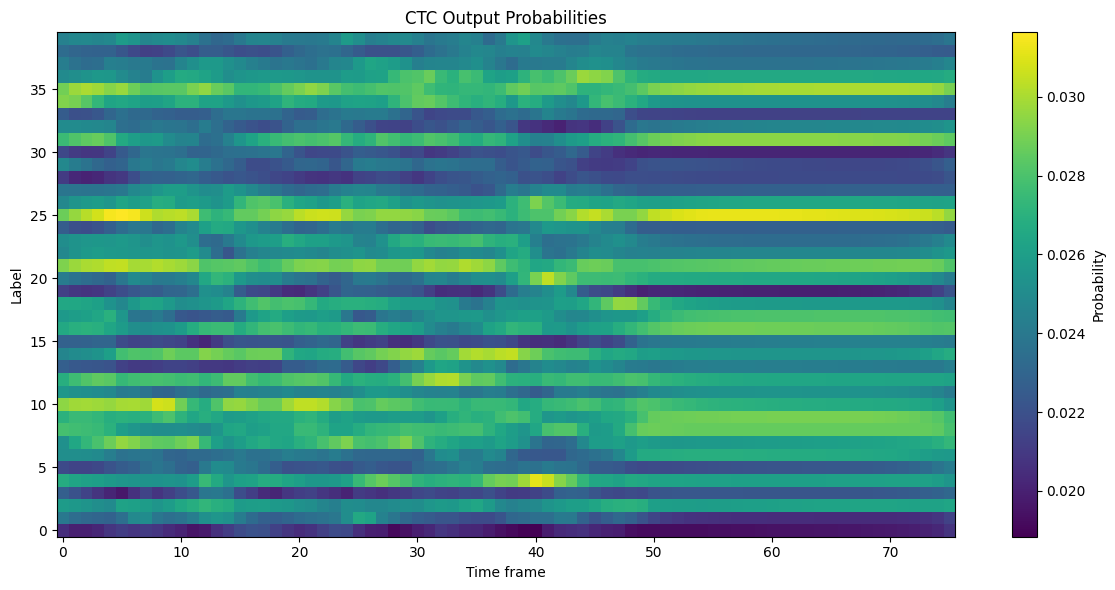

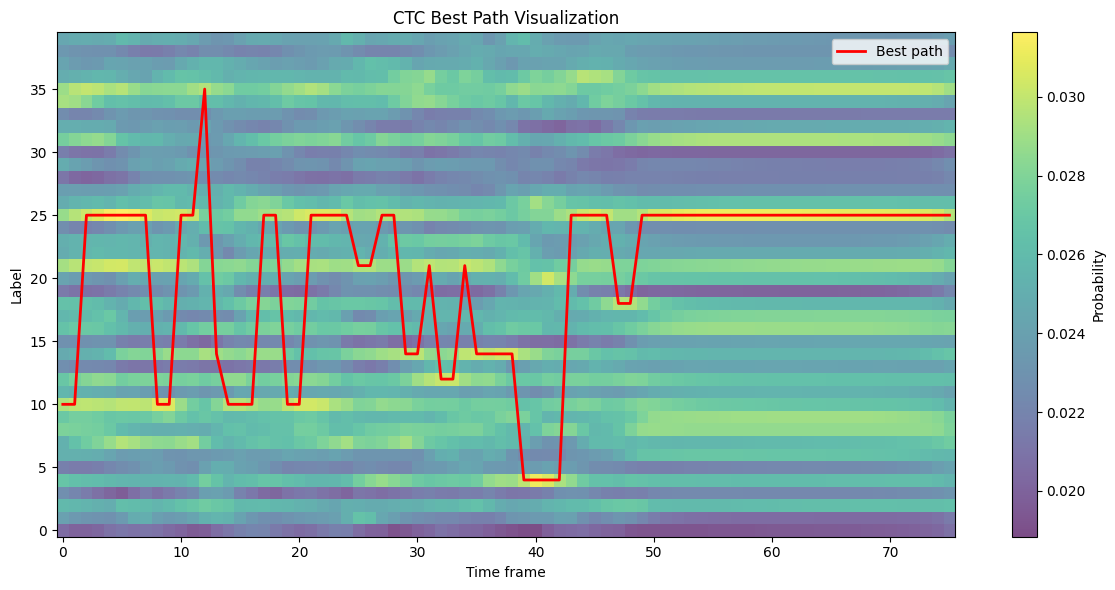

In [ ]:
# Call the plotting functions with available data

# Visualize CTC output probabilities
plot_ctc_alignment(log_probs)

# Visualize the CTC Viterbi best path
plot_best_path(log_probs, best_path)

---
# Quick Reference Summary

## HMM Key Functions
| Task | Code |
|------|------|
| Create model | `model = hmm.GaussianHMM(n_components=5)` |
| Train | `model.fit(X, lengths)` |
| Log-likelihood | `model.score(X)` |
| Predict states | `model.predict(X)` |
| Decode | `model.decode(X, algorithm='viterbi')` |

## CTC Key Functions  
| Task | Code |
|------|------|
| Create loss | `ctc_loss = nn.CTCLoss(blank=0)` |
| Compute loss | `loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)` |
| Log softmax | `log_probs = F.log_softmax(logits, dim=-1)` |
| Greedy decode | `argmax then collapse repeats and remove blanks` |

## Key Documentation Links
- **hmmlearn**: https://hmmlearn.readthedocs.io/en/stable/
- **CTCLoss**: https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html
- **CTC Tutorial**: https://distill.pub/2017/ctc/
- **torchaudio CTC**: https://pytorch.org/audio/stable/tutorials/ctc_forced_alignment_api_tutorial.html
- **librosa MFCC**: https://librosa.org/doc/main/generated/librosa.feature.mfcc.html
- **Rabiner HMM Tutorial**: https://www.cs.ubc.ca/~murphyk/Bayes/rabiner.pdf